# Acoustic FWI(VP) with entire data

## Author: M. Ravasi

This notebook performs acoustic FWI parametrized in velocity using the entire dataset. Since the data is polluted by noise, a spatial smoothing regularization term is added to the objective function. For comparison, we will also run FWI without any regularizer.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.optimize import minimize
from pylops.basicoperators import Identity, Laplacian

from devito import configuration
from tqdm.notebook import tqdm

from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.loss.l2 import L2
from devitofwi.postproc.acoustic import create_mask_value, PostProcessVP

configuration['log-level'] = 'ERROR'

/home/ravasim/Documents/2024/Projects/Devito-fwi/devitofwi/waveengine/acoustic.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
clear_devito_cache()

In [3]:
# Callback to track model error
def fwi_callback(xk, vp, vp_error, vp_tmp):
    vp_tmp[0] = xk
    vp_error.append(np.linalg.norm((xk - vp.reshape(-1))/vp.reshape(-1)))

## Parameters 

In [4]:
# Model and aquisition parameters (in km, s, and Hz units)
par = {'nx':601,   'dx':0.015,    'ox':0,
       'nz':221,   'dz':0.015,    'oz':0,
       'ns':20,    'ds':0.300,    'os':1.,  'sz':0,
       'nr':300,   'dr':0.030,    'or':0,   'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':15,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

## Acquisition set-up

In [5]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

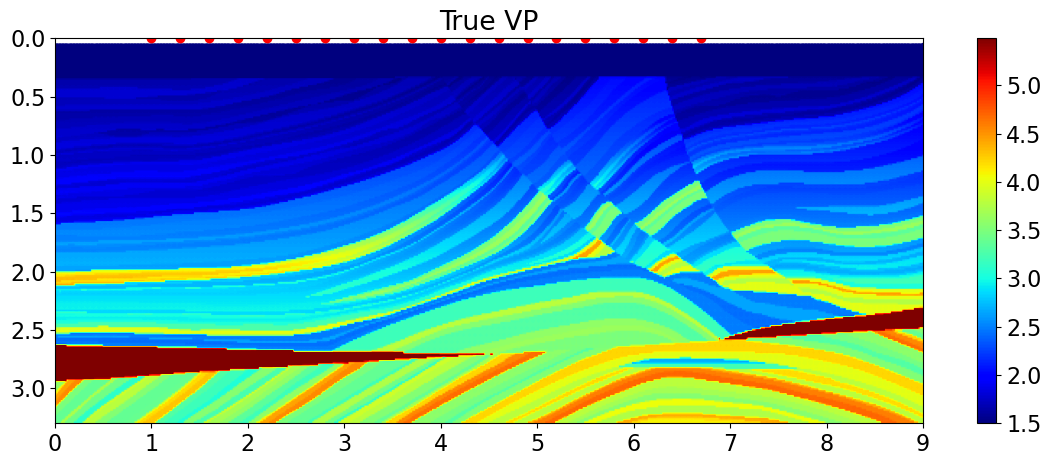

In [6]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = create_mask_value(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

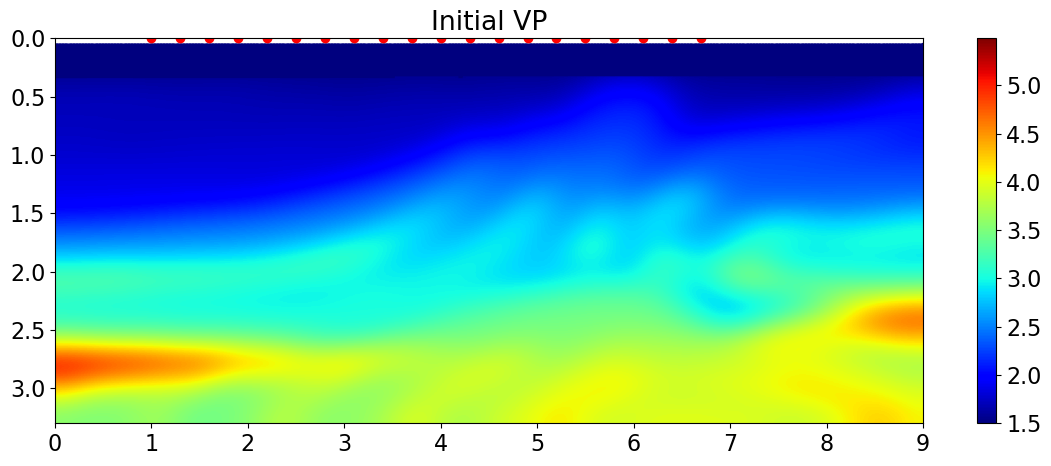

In [7]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [8]:
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vp=vp_true, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      clearcache=False);

In [9]:
# Model data
dclean, dtobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
# Add noise to data
sigman = 1e-6
dobs = dclean + np.random.normal(0, sigman, dclean.shape)

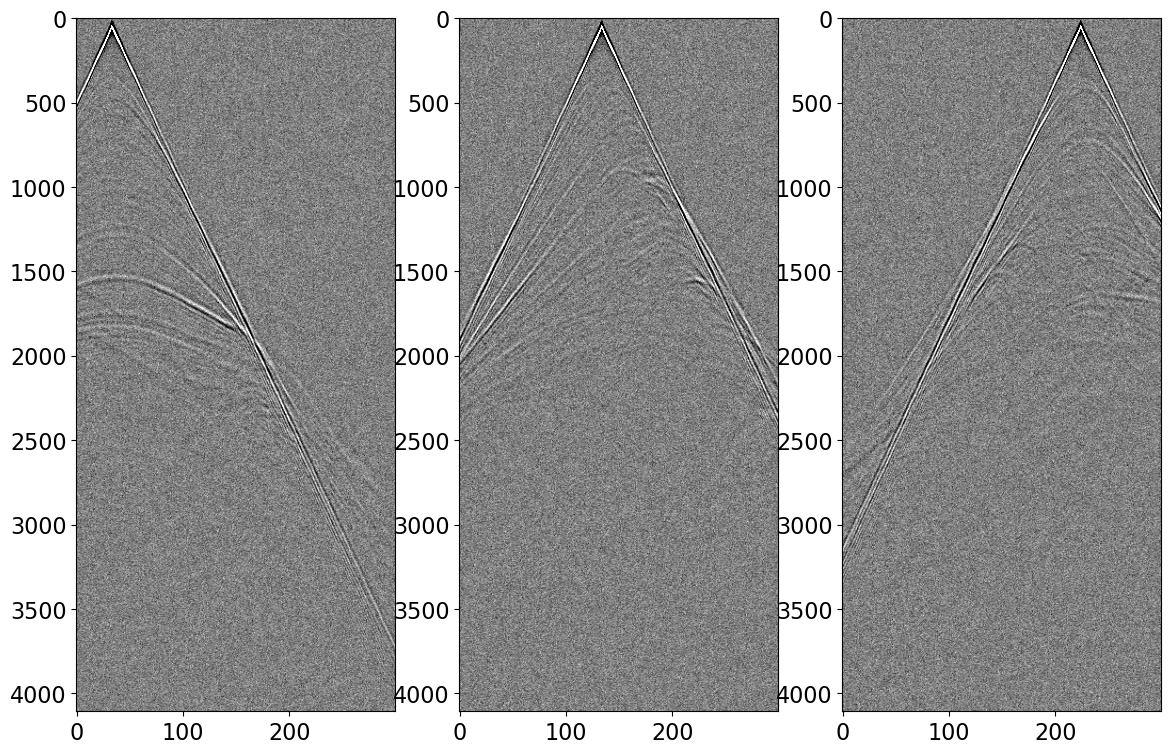

In [11]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

## Inversion with L-BFGS

### Unregularized

In [12]:
# Define loss as simple unweighted L2 difference of observed and modelled data
l2loss = L2(Identity(int(np.prod(dobs.shape[1:]))), dobs.reshape(par['ns'], -1), sigma=1e-2)

ainv = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vprange=(vp_true.min(), vp_true.max()),
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      loss=l2loss, clearcache=True);
                      # checkpointing=True

  0%|          | 0/20 [00:00<?, ?it/s]

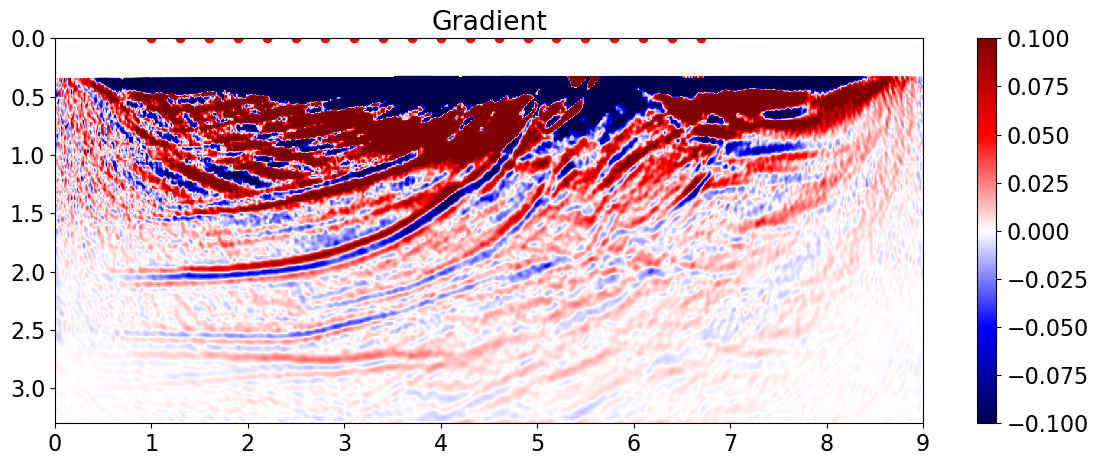

In [13]:
# Compute first gradient and find scaling
postproc = PostProcessVP(scaling=1, mask=msk)
loss, direction = ainv._loss_grad(vp_init, postprocess=postproc.apply)

scaling = direction.max()

plt.figure(figsize=(14, 5))
plt.imshow(direction.T / scaling, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Gradient')
plt.axis('tight');

In [14]:
# FWI with L-BFGS
ftol = 1e-10
maxiter = 100
maxfun = 200
vp_error = []
vp_tmp = [0, ]
convertvp = None
postproc = PostProcessVP(scaling=scaling, mask=msk)

nl = minimize(ainv.loss_grad, vp_init.ravel(), method='L-BFGS-B', jac=True,
              args=(convertvp, postproc.apply),
              callback=lambda x: fwi_callback(x, vp=vp_true, vp_error=vp_error, vp_tmp=vp_tmp), 
              options={'ftol':ftol, 'maxiter':maxiter, 'maxfun':maxfun, 'disp':True})

  0%|          | 0/20 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81392D+04    |proj g|=  5.49994D+00


 This problem is unconstrained.


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  3.79784D+04    |proj g|=  2.34891D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  3.78949D+04    |proj g|=  1.85177D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  3.77852D+04    |proj g|=  1.98734D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  3.76715D+04    |proj g|=  3.69436D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  3.76069D+04    |proj g|=  2.24391D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  3.75377D+04    |proj g|=  2.49055D+00


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  3.74886D+04    |proj g|=  2.65836D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  3.74488D+04    |proj g|=  5.49675D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  3.74120D+04    |proj g|=  1.21336D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  3.73852D+04    |proj g|=  1.01535D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  3.73558D+04    |proj g|=  1.68270D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  3.73242D+04    |proj g|=  1.05795D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  3.73031D+04    |proj g|=  2.44057D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  3.72844D+04    |proj g|=  7.90290D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  3.72713D+04    |proj g|=  1.17581D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  3.72533D+04    |proj g|=  1.09804D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  3.72361D+04    |proj g|=  1.39497D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  3.72184D+04    |proj g|=  9.86059D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  3.72069D+04    |proj g|=  7.65593D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  3.71958D+04    |proj g|=  6.70026D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  3.71801D+04    |proj g|=  1.04443D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  3.71670D+04    |proj g|=  5.35884D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  3.71584D+04    |proj g|=  5.58534D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  3.71467D+04    |proj g|=  6.88467D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  3.71376D+04    |proj g|=  1.21084D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  3.71276D+04    |proj g|=  6.66325D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  3.71220D+04    |proj g|=  7.46907D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  3.71167D+04    |proj g|=  5.92829D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  3.71091D+04    |proj g|=  4.52476D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  3.70991D+04    |proj g|=  6.44703D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  3.70914D+04    |proj g|=  8.37909D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  3.70848D+04    |proj g|=  6.22271D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  3.70797D+04    |proj g|=  1.02790D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  3.70738D+04    |proj g|=  6.56468D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  3.70707D+04    |proj g|=  5.35397D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  3.70645D+04    |proj g|=  5.82144D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  3.70588D+04    |proj g|=  6.80597D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  3.70541D+04    |proj g|=  5.67277D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  3.70498D+04    |proj g|=  5.07456D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  3.70455D+04    |proj g|=  4.47041D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  3.70412D+04    |proj g|=  5.16099D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  3.70359D+04    |proj g|=  4.31895D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  3.70315D+04    |proj g|=  4.99436D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  3.70281D+04    |proj g|=  5.95483D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  3.70244D+04    |proj g|=  4.43365D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  3.70235D+04    |proj g|=  1.46178D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  3.70174D+04    |proj g|=  5.15921D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  3.70160D+04    |proj g|=  3.21526D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  3.70130D+04    |proj g|=  4.98301D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  3.70092D+04    |proj g|=  6.95882D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   51    f=  3.70061D+04    |proj g|=  5.12386D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   52    f=  3.70030D+04    |proj g|=  3.76189D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   53    f=  3.70000D+04    |proj g|=  4.76861D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   54    f=  3.69969D+04    |proj g|=  6.79707D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   55    f=  3.69941D+04    |proj g|=  2.60607D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   56    f=  3.69916D+04    |proj g|=  2.57947D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   57    f=  3.69885D+04    |proj g|=  4.40474D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   58    f=  3.69867D+04    |proj g|=  8.05175D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   59    f=  3.69837D+04    |proj g|=  4.12461D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   60    f=  3.69822D+04    |proj g|=  3.39396D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   61    f=  3.69802D+04    |proj g|=  3.26989D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   62    f=  3.69770D+04    |proj g|=  5.10219D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   63    f=  3.69745D+04    |proj g|=  7.38837D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   64    f=  3.69719D+04    |proj g|=  2.43660D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   65    f=  3.69703D+04    |proj g|=  2.99568D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   66    f=  3.69686D+04    |proj g|=  4.01602D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   67    f=  3.69667D+04    |proj g|=  4.01069D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   68    f=  3.69649D+04    |proj g|=  3.51227D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   69    f=  3.69628D+04    |proj g|=  2.10116D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   70    f=  3.69591D+04    |proj g|=  6.85663D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   71    f=  3.69573D+04    |proj g|=  7.83449D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   72    f=  3.69553D+04    |proj g|=  2.54630D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   73    f=  3.69540D+04    |proj g|=  2.85218D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   74    f=  3.69526D+04    |proj g|=  4.54920D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   75    f=  3.69512D+04    |proj g|=  2.91732D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   76    f=  3.69491D+04    |proj g|=  2.20712D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   77    f=  3.69475D+04    |proj g|=  2.39042D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   78    f=  3.69461D+04    |proj g|=  5.83569D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   79    f=  3.69436D+04    |proj g|=  3.67409D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   80    f=  3.69425D+04    |proj g|=  2.24214D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   81    f=  3.69410D+04    |proj g|=  2.19908D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   82    f=  3.69393D+04    |proj g|=  2.31570D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   83    f=  3.69380D+04    |proj g|=  4.67164D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   84    f=  3.69362D+04    |proj g|=  2.01055D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   85    f=  3.69350D+04    |proj g|=  2.01236D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   86    f=  3.69337D+04    |proj g|=  2.39221D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   87    f=  3.69324D+04    |proj g|=  4.65170D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   88    f=  3.69310D+04    |proj g|=  2.82893D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   89    f=  3.69301D+04    |proj g|=  2.46230D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   90    f=  3.69292D+04    |proj g|=  2.03942D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   91    f=  3.69278D+04    |proj g|=  2.53180D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   92    f=  3.69266D+04    |proj g|=  2.17518D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   93    f=  3.69255D+04    |proj g|=  2.07708D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   94    f=  3.69243D+04    |proj g|=  2.00638D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   95    f=  3.69231D+04    |proj g|=  3.24665D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   96    f=  3.69217D+04    |proj g|=  2.59730D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   97    f=  3.69205D+04    |proj g|=  2.23217D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   98    f=  3.69193D+04    |proj g|=  2.87410D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   99    f=  3.69184D+04    |proj g|=  2.76836D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate  100    f=  3.69176D+04    |proj g|=  1.99467D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    100    102      1     0     0   1.995D-01   3.692D+04
  F =   36917.603784058963     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


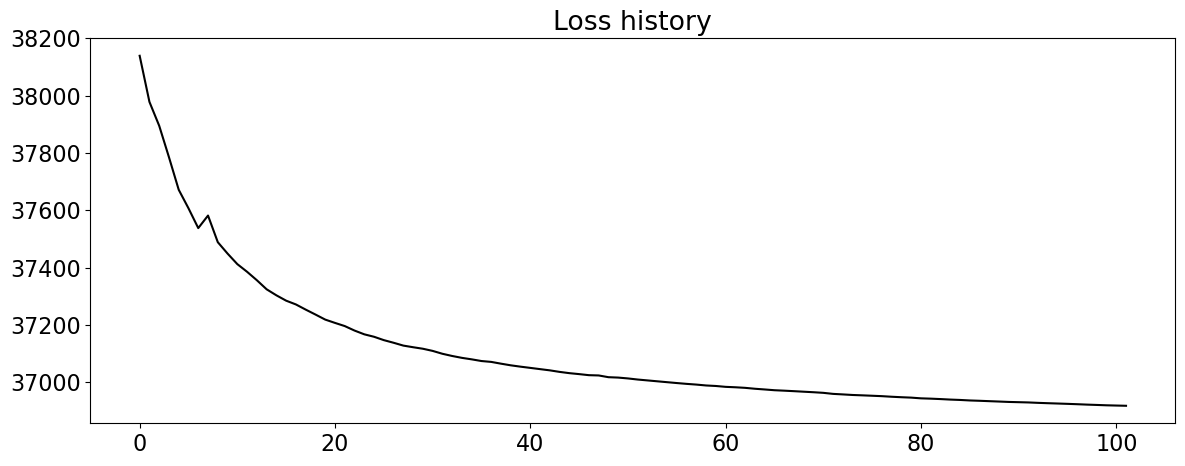

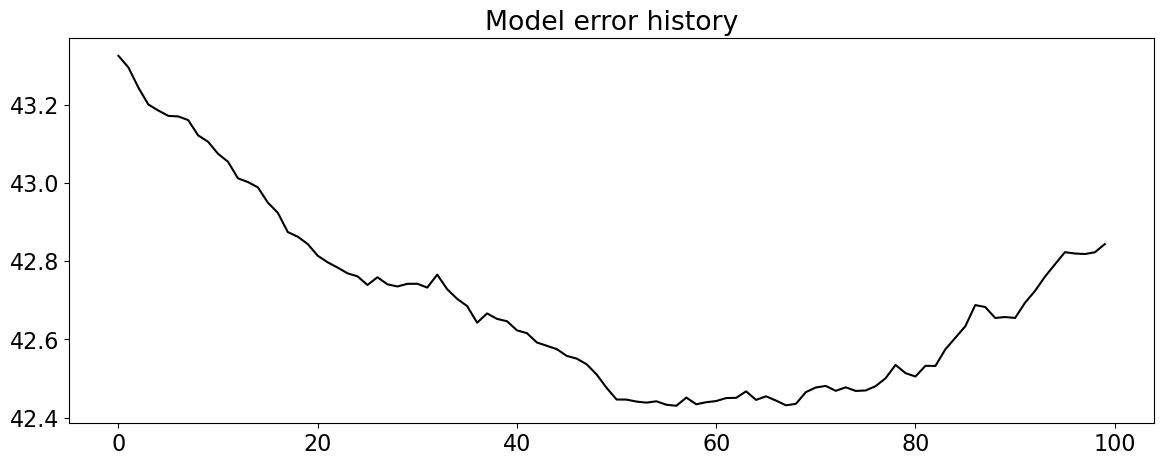

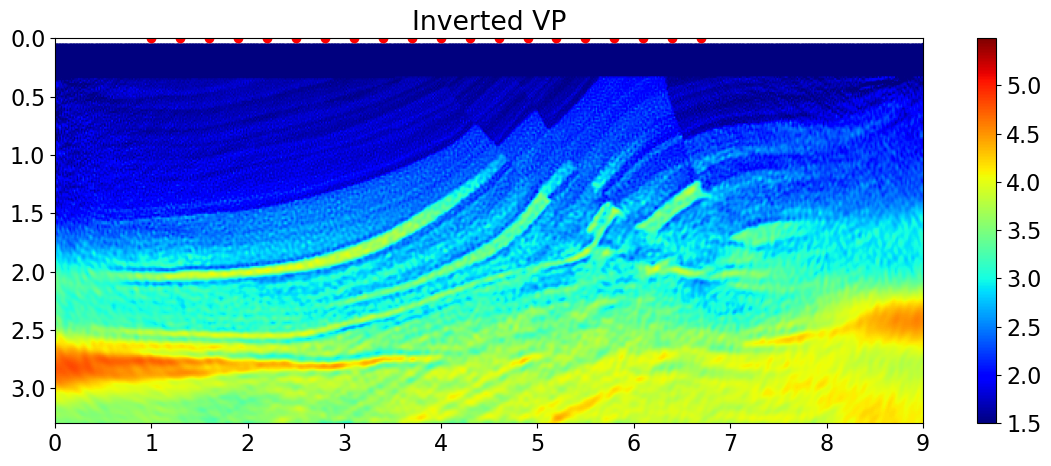

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(ainv.losshistory, 'k')
plt.title('Loss history')

plt.figure(figsize=(14, 5))
plt.plot(vp_error, 'k')
plt.title('Model error history');

vp_inv = nl.x.reshape(shape)

plt.figure(figsize=(14, 5))
plt.imshow(vp_inv.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Inverted VP')
plt.axis('tight');

### Regularized

In [16]:
# Define regularizer and add it to the fwi loss function
l2loss = L2(Identity(int(np.prod(dobs.shape[1:]))), dobs.reshape(par['ns'], -1), sigma=1e-2)
ainv = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vprange=(vp_true.min(), vp_true.max()),
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      loss=l2loss, clearcache=True);
                      # checkpointing=True

Lapop  = Laplacian(shape, weights=[1, 1], dtype='float32')
lapreg = L2(Op=Lapop, sigma=1e0)

ainv_reg = ainv + lapreg

In [17]:
# Regularized FWI with L-BFGS
ftol = 1e-10
maxiter = 100
maxfun = 200
vp_error = []
vp_tmp = [0, ]
convertvp = None
postproc = PostProcessVP(scaling=scaling, mask=msk)

nl = minimize(ainv_reg.loss_grad, vp_init.ravel(), method='L-BFGS-B', jac=True,
              args=(dict(convertvp=convertvp, postprocess=postproc.apply), dict(i=None)),
              callback=lambda x: fwi_callback(x, vp=vp_true, vp_error=vp_error, vp_tmp=vp_tmp), 
              options={'ftol':ftol, 'maxiter':maxiter, 'maxfun':maxfun, 'disp':True})

  0%|          | 0/20 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81472D+04    |proj g|=  5.26401D+00


 This problem is unconstrained.


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  3.79861D+04    |proj g|=  2.34989D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  3.79048D+04    |proj g|=  2.12136D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  3.78031D+04    |proj g|=  2.20430D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  3.77071D+04    |proj g|=  4.53776D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  3.76553D+04    |proj g|=  2.76602D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  3.75917D+04    |proj g|=  2.85240D+00


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  3.75343D+04    |proj g|=  4.49228D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  3.74993D+04    |proj g|=  2.88173D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  3.74604D+04    |proj g|=  9.82070D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  3.74376D+04    |proj g|=  2.27919D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  3.74126D+04    |proj g|=  1.56347D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  3.73957D+04    |proj g|=  1.10554D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  3.73659D+04    |proj g|=  9.92521D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  3.73487D+04    |proj g|=  1.72510D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  3.73318D+04    |proj g|=  1.25942D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  3.73208D+04    |proj g|=  1.06528D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  3.73119D+04    |proj g|=  4.85911D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  3.73006D+04    |proj g|=  8.31729D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  3.72907D+04    |proj g|=  8.21431D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  3.72835D+04    |proj g|=  7.23929D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  3.72768D+04    |proj g|=  4.89242D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  3.72682D+04    |proj g|=  5.33782D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  3.72630D+04    |proj g|=  1.31916D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  3.72557D+04    |proj g|=  3.80514D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  3.72522D+04    |proj g|=  4.36766D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  3.72478D+04    |proj g|=  6.90079D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  3.72422D+04    |proj g|=  7.67405D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  3.72399D+04    |proj g|=  5.91091D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  3.72360D+04    |proj g|=  3.46613D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  3.72330D+04    |proj g|=  5.09803D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  3.72311D+04    |proj g|=  1.00552D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  3.72295D+04    |proj g|=  7.06799D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  3.72262D+04    |proj g|=  3.95814D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  3.72250D+04    |proj g|=  3.73762D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  3.72232D+04    |proj g|=  3.93285D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  3.72228D+04    |proj g|=  4.82010D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  3.72218D+04    |proj g|=  6.10883D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  3.72211D+04    |proj g|=  5.07246D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  3.72187D+04    |proj g|=  4.16368D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  3.72181D+04    |proj g|=  6.01657D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  3.72172D+04    |proj g|=  3.56723D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  3.72163D+04    |proj g|=  2.47644D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  3.72162D+04    |proj g|=  2.65884D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  3.72154D+04    |proj g|=  3.13730D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  3.72151D+04    |proj g|=  2.34449D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  3.72148D+04    |proj g|=  2.41973D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  3.72145D+04    |proj g|=  2.24812D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  3.72145D+04    |proj g|=  2.24812D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  3.72142D+04    |proj g|=  2.03627D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  3.72138D+04    |proj g|=  1.71107D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   51    f=  3.72131D+04    |proj g|=  2.83156D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   52    f=  3.72124D+04    |proj g|=  2.92661D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   53    f=  3.72122D+04    |proj g|=  2.96376D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   54    f=  3.72119D+04    |proj g|=  2.43576D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   55    f=  3.72118D+04    |proj g|=  1.93472D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   56    f=  3.72117D+04    |proj g|=  1.64441D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   57    f=  3.72116D+04    |proj g|=  1.18927D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   58    f=  3.72116D+04    |proj g|=  1.18906D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   59    f=  3.72116D+04    |proj g|=  1.18471D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   60    f=  3.72116D+04    |proj g|=  1.17678D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   61    f=  3.72116D+04    |proj g|=  1.15306D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   62    f=  3.72116D+04    |proj g|=  1.15377D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   63    f=  3.72116D+04    |proj g|=  2.05498D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   64    f=  3.72116D+04    |proj g|=  2.05468D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   65    f=  3.72116D+04    |proj g|=  2.00376D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   66    f=  3.72116D+04    |proj g|=  2.00378D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   67    f=  3.72115D+04    |proj g|=  1.09316D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   68    f=  3.72114D+04    |proj g|=  1.74952D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   69    f=  3.72113D+04    |proj g|=  3.48342D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   70    f=  3.72112D+04    |proj g|=  3.71476D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     70    204      3     0     0   3.715D-01   3.721D+04
  F =   37211.239250720158     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


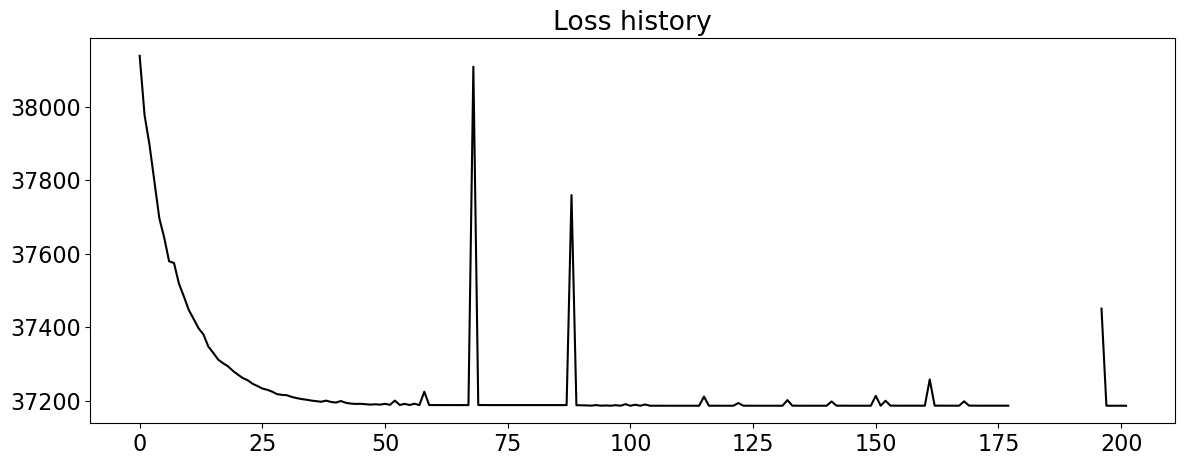

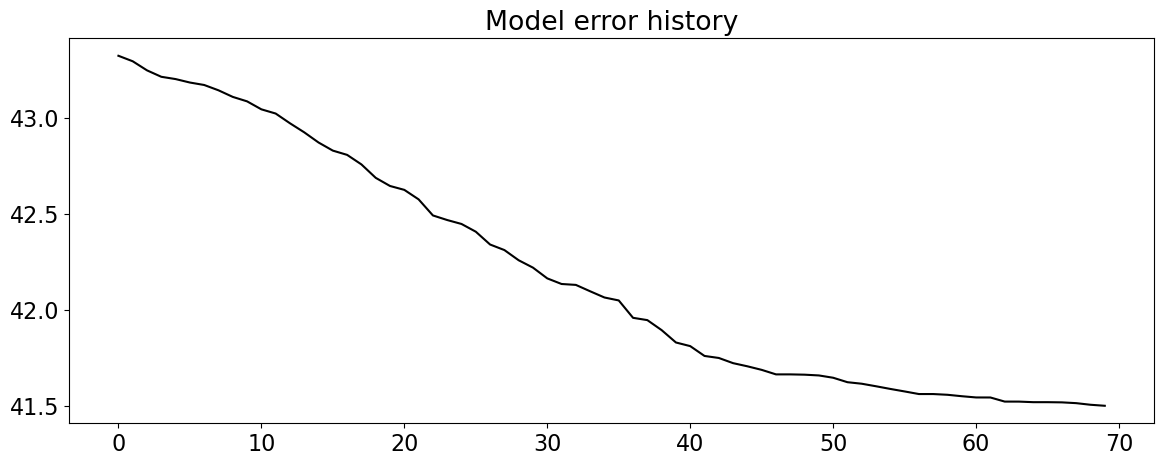

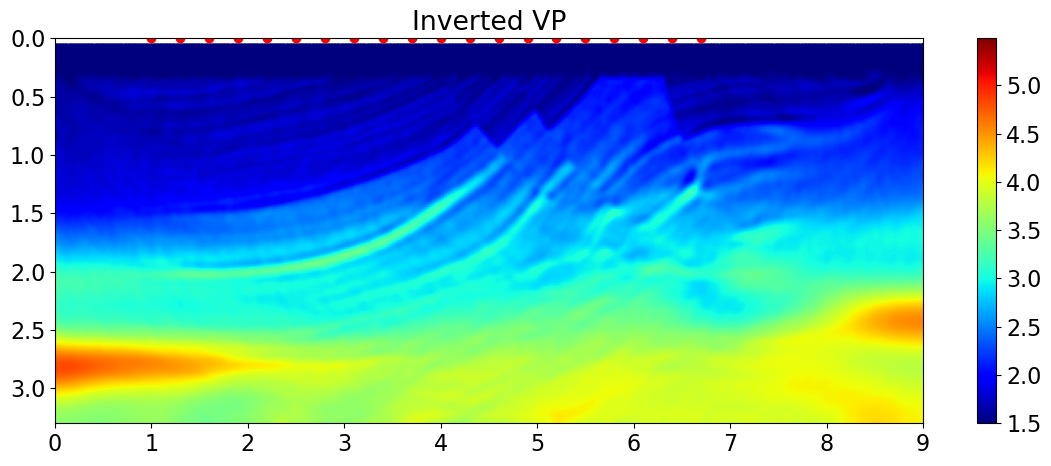

In [18]:
plt.figure(figsize=(14, 5))
plt.plot(ainv.losshistory, 'k')
plt.title('Loss history')

plt.figure(figsize=(14, 5))
plt.plot(vp_error, 'k')
plt.title('Model error history');

vp_inv = nl.x.reshape(shape)

plt.figure(figsize=(14, 5))
plt.imshow(vp_inv.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Inverted VP')
plt.axis('tight');

In [19]:
# Model data with inverted velocity model and compare with observed data
ainvfinal = AcousticWave2D(shape, origin, spacing, 
                           x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                           0., tmax,  
                           vp=vp_inv, 
                           src_type="Ricker", f0=par['freq'],
                           space_order=space_order, nbl=nbl)

dinv = ainvfinal.mod_allshots(dt=dtobs)[0]

  0%|          | 0/20 [00:00<?, ?it/s]

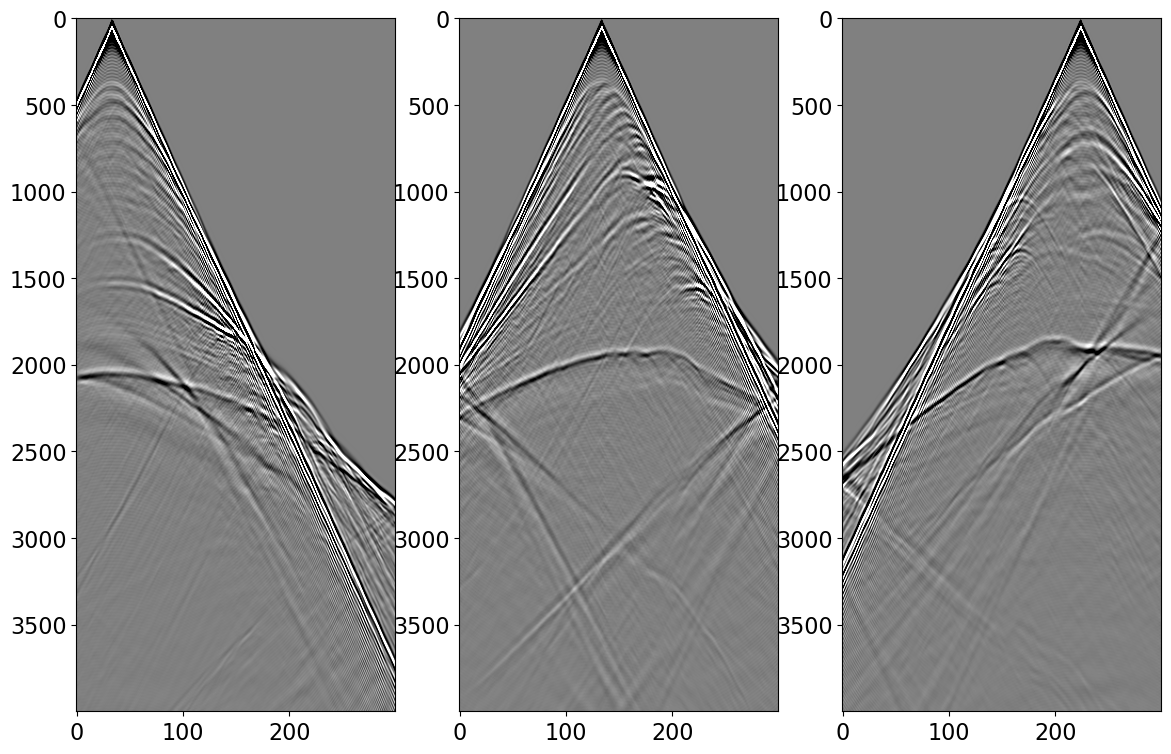

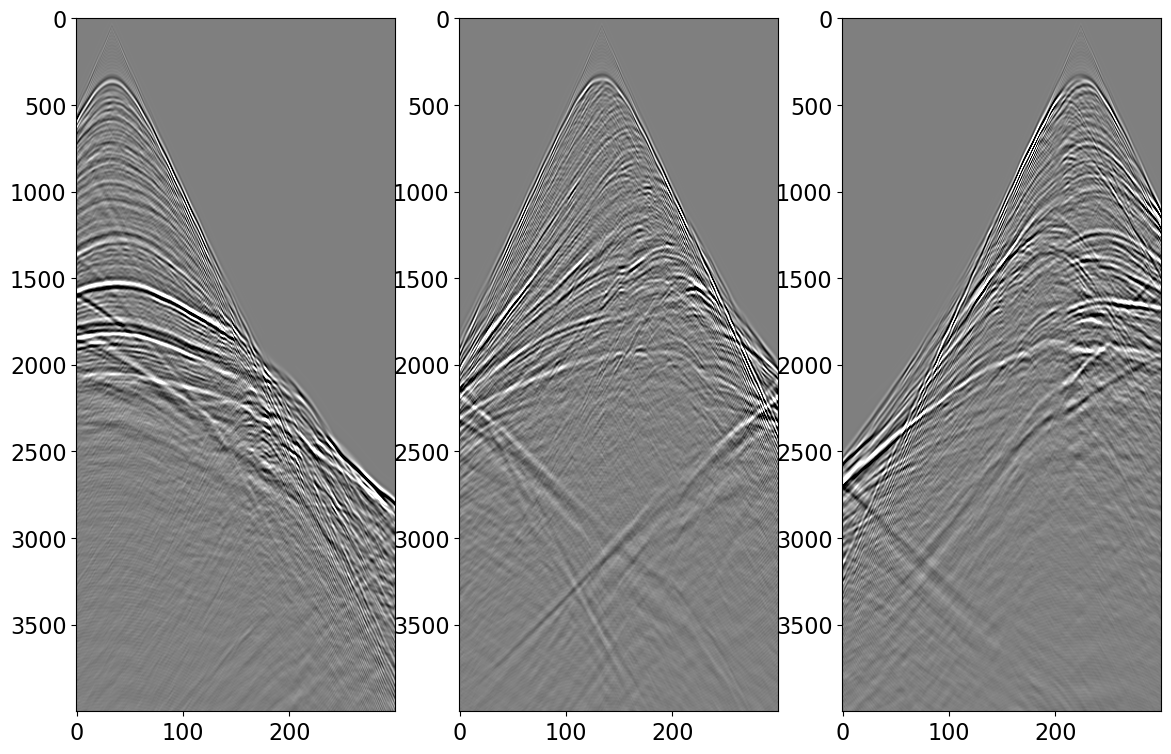

In [20]:
ntmax = 4000
d_vmin, d_vmax = np.percentile(np.hstack(dinv).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dinv[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dclean[ishot, :ntmax] - dinv[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)